In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

In [3]:
ml_client = MLClient(DefaultAzureCredential(),
                    subscription_id= "59370939-111d-4222-9d04-935c1efb51d7",
                    resource_group_name= "santosh24496-rg",
                    workspace_name= "ML_Practice")

In [4]:
data_asset = ml_client.data.list()
for da in data_asset:
    print(da.name)

yt_shorts
food_demand_forecast
apple_stock_price


In [5]:
data_asset = ml_client.data.get(name='apple_stock_price', version = '1')
print(data_asset.path)

azureml://subscriptions/59370939-111d-4222-9d04-935c1efb51d7/resourcegroups/santosh24496-rg/workspaces/ML_Practice/datastores/workspaceblobstore/paths/UI/2025-12-02_093119_UTC/P614 DATASET.csv


In [6]:
dataset = pd.read_csv(data_asset.path)
dataset.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
5,2012-01-10,60.844284,60.857143,60.214287,60.462856,52.248333,64549100
6,2012-01-11,60.382858,60.407143,59.901428,60.364285,52.163139,53771200
7,2012-01-12,60.325714,60.414288,59.821430,60.198570,52.019955,53146800
8,2012-01-13,59.957142,60.064285,59.808571,59.972858,51.824898,56505400
9,2012-01-17,60.599998,60.855713,60.422855,60.671429,52.428562,60724300


# Pre- Processing

In [7]:
data = dataset.reset_index()['Close']
data.head()

0    58.747143
1    59.062859
2    59.718571
3    60.342857
4    60.247143
Name: Close, dtype: float64

## Scaling the Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(data).reshape(-1,1))
df

array([[0.01254462],
       [0.01388393],
       [0.01666555],
       ...,
       [0.99317022],
       [0.99270351],
       [1.        ]], shape=(2011, 1))

## Split the data

In [10]:
h = 30
X_train = df[:-h]
X_test = df[-h:]

In [11]:
X_train

array([[0.01254462],
       [0.01388393],
       [0.01666555],
       ...,
       [0.8746023 ],
       [0.88525012],
       [0.87748706]], shape=(1981, 1))

<Axes: ylabel='Count'>

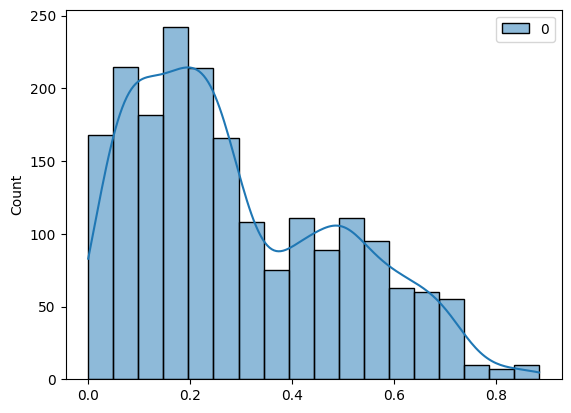

In [12]:
sns.histplot(data = X_train, kde = True)


# Feature Engineering

In [13]:
X_test.shape

(30, 1)

In [14]:
lookback_test = np.concatenate([X_train[-30:,],X_test], axis = 0)
lookback_test

array([[0.72633947],
       [0.72655159],
       [0.71526747],
       [0.72642433],
       [0.73940527],
       [0.76536722],
       [0.76392484],
       [0.76159172],
       [0.75756163],
       [0.761422  ],
       [0.76621564],
       [0.78360838],
       [0.78127525],
       [0.79493489],
       [0.79663178],
       [0.80935821],
       [0.8198363 ],
       [0.79540153],
       [0.79527427],
       [0.81860605],
       [0.84855562],
       [0.85568239],
       [0.85411282],
       [0.85457939],
       [0.86386969],
       [0.86688171],
       [0.8756205 ],
       [0.8746023 ],
       [0.88525012],
       [0.87748706],
       [0.89072252],
       [0.89640697],
       [0.89297085],
       [0.87982018],
       [0.87481449],
       [0.87383875],
       [0.89331016],
       [0.88448657],
       [0.89954612],
       [0.89704327],
       [0.88393507],
       [0.86395461],
       [0.87366903],
       [0.88995884],
       [0.91172104],
       [0.89564342],
       [0.90226115],
       [0.911

In [15]:
lookback_test.shape

(60, 1)

In [16]:
X_train_data = []
X_test_data = []
y_train_data = []
y_test_data = []

for i in range(len(X_train)-30):
    X_train_data.append(X_train[i:(i+30),0])
    y_train_data.append(X_train[i+30,0])

for j in range(len(lookback_test)-30):
    X_test_data.append(lookback_test[j:(j+30),0])
    y_test_data.append(lookback_test[j+30,0])


In [17]:
X_train_data, y_train_data = np.array(X_train_data), np.array(y_train_data)
X_train_data.shape, y_train_data.shape

((1951, 30), (1951,))

In [18]:
X_test_data, y_test_data = np.array(X_test_data), np.array(y_test_data)
X_test_data.shape, y_test_data.shape

((30, 30), (30,))

In [19]:
X_train_3d = X_train_data.reshape(X_train_data.shape[0],X_train_data.shape[1],1)
X_test_3d = X_test_data.reshape(X_test_data.shape[0],X_test_data.shape[1],1)

In [20]:
X_train_3d.shape

(1951, 30, 1)

# LSTM Model 

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasRegressor

2025-12-14 07:27:04.310954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def build_ml():
    model = Sequential()
    model.add(LSTM(units = 128, input_shape = (X_train_3d.shape[1], X_train_3d.shape[2]),
                    return_sequences= False))
    model.add(Dropout(0.1))                
    model.add(Dense(1, activation  = 'linear'))
    optimizer = Adam()
    model.compile(optimizer = optimizer, loss ='mean_squared_error')
    return model

In [22]:
early_stop = EarlyStopping(monitor= 'val_loss',patience=5, restore_best_weights=True)

In [24]:
lstm_ml = KerasRegressor(model=build_ml, verbose=0, callbacks=[early_stop], epochs = 15, batch_size= 32)

In [25]:
lstm_ml.fit(X_train_3d, y_train_data)

2025-12-12 15:14:13.101387: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


,model,<function bui...x716f7cc35750>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,32
,validation_batch_size,None
,verbose,0
,callbacks,[<keras.src.ca...x716f7cc0be80>]


In [26]:
yhat_train = lstm_ml.predict(X_train_3d)
yhat_test = lstm_ml.predict(X_test_3d)

In [27]:
yhat_train = scaler.inverse_transform(yhat_train.reshape(-1,1))
yhat_test = scaler.inverse_transform(yhat_test.reshape(-1,1))

In [28]:
X_test_inve = scaler.inverse_transform(X_test)

In [29]:
X_test_inve

array([[265.76001 ],
       [267.100006],
       [266.290009],
       [263.190002],
       [262.01001 ],
       [261.779999],
       [266.369995],
       [264.290009],
       [267.839996],
       [267.25    ],
       [264.160004],
       [259.450012],
       [261.73999 ],
       [265.579987],
       [270.709991],
       [266.920013],
       [268.480011],
       [270.769989],
       [271.459991],
       [275.149994],
       [279.859985],
       [280.410004],
       [279.73999 ],
       [280.019989],
       [279.440002],
       [284.      ],
       [284.269989],
       [289.910004],
       [289.799988],
       [291.519989]])

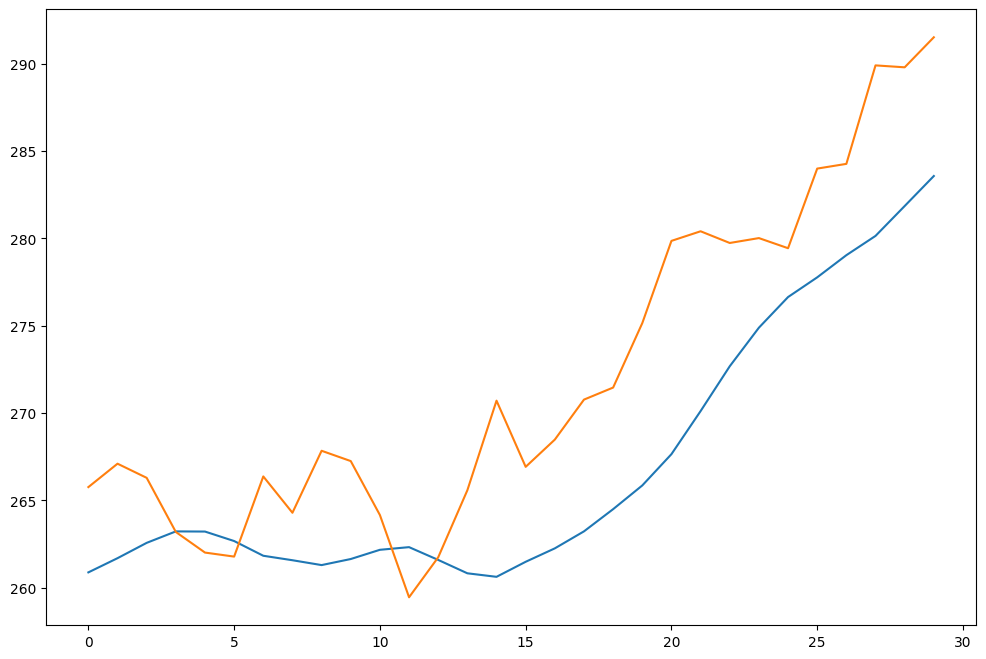

In [30]:
plt.figure(figsize=(12,8))
plt.plot(yhat_test)
plt.plot(X_test_inve)

# Hyperparameter Tuning

In [23]:
import keras_tuner as kt

In [24]:
def build_lstm(hp):
    model = Sequential()

    model.add(LSTM(
        units = hp.Int('lstm_units', min_value = 32, max_value = 256, step = 32),
        input_shape = (X_train_3d.shape[1], X_train_3d.shape[2]),
        activation = hp.Choice('activation',values = ['tanh' , 'relu']),
        kernel_initializer= hp.Choice('initializer',values = ['uniform','normal']),
        return_sequences= False
    ))

    model.add(Dropout(hp.Float('dropout', min_value = 0.1, max_value = 0.5, step = 0.1)))
    model.add(Dense(1, activation= 'linear'))

    lr = hp.Choice('learning_rate', values = [0.1,0.01,0.001,0.0001])
    opt = hp.Choice('optimizer', values = ['adam', 'rmsprop'])

    if opt == 'adam':
        optimizer = Adam(learning_rate= lr)
    elif opt == 'rmsprop':
        optimizer = RMSprop(learning_rate= lr)
    
    model.compile(optimizer = optimizer, loss = 'mse')
    return model


In [25]:
lstm_search = kt.RandomSearch(build_lstm, objective = 'val_loss', max_trials = 10,
                                executions_per_trial = 1, seed = 42)
lstm_search.search(X_train_3d, y_train_data, 
                    epochs = 15, batch_size = 64, validation_split=0.2, callbacks = [early_stop])
                    

Trial 10 Complete [00h 00m 31s]
val_loss: 0.009936175309121609

Best val_loss So Far: 0.0003293421759735793
Total elapsed time: 00h 06m 48s


In [26]:
best_lstm1 = lstm_search.get_best_models(num_models =1)[0]

In [27]:
best_lstm1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
best_lstm1_params = lstm_search.get_best_hyperparameters(num_trials = 1)[0]

In [29]:
best_lstm1_params.values

{'lstm_units': 32,
 'activation': 'tanh',
 'initializer': 'normal',
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'optimizer': 'rmsprop'}

In [30]:
best_lstm1.evaluate(X_test_3d, y_test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step - loss: 2.4067e-04


0.00024066545302048326

# Final Model

In [31]:
import tensorflow as tf
#tf.random.set_seed(42)

In [32]:
def final_lstm():
    model = Sequential()

    model.add(LSTM(units = 32, activation='tanh', kernel_initializer='normal',
                    input_shape = (X_train_3d.shape[1], X_train_3d.shape[2]),
                    return_sequences=False))                    
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'linear'))
    model.compile(optimizer = RMSprop(learning_rate=0.01), loss = 'mse')
    return model

In [33]:
final_lstm = KerasRegressor(model= final_lstm, epochs = 15, batch_size= 64,verbose = 0,
                            callbacks = [early_stop], validation_split=0.2 )

In [34]:
final_lstm.fit(X_train_3d, y_train_data)

,model,<function fin...x790f9679b370>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,64
,validation_batch_size,None
,verbose,0
,callbacks,[<keras.src.ca...x790ef2e8dff0>]


In [35]:
yhat_train = final_lstm.predict(X_train_3d)
yhat_test = final_lstm.predict(X_test_3d)

In [36]:
yhat_train = scaler.inverse_transform(yhat_train.reshape(-1,1))
yhat_test = scaler.inverse_transform(yhat_test.reshape(-1,1))

In [37]:
y_train_inve = scaler.inverse_transform(y_train_data.reshape(-1,1))
y_test_inve = scaler.inverse_transform(y_test_data.reshape(-1,1))

In [38]:
from sklearn.metrics import mean_squared_error, r2_score

final_train_rmse = np.sqrt(mean_squared_error(y_train_inve, yhat_train))
final_test_rmse = np.sqrt(mean_squared_error(y_test_inve, yhat_test))


final_train_rmse, final_test_rmse

(np.float64(2.8572875369144954), np.float64(5.066753154628699))

In [39]:
datadates = dataset.copy()

In [40]:
datadates['Date'] = pd.to_datetime(datadates['Date'])
datadates.set_index('Date', inplace = True)

In [41]:
train_dates = datadates.index[30:30+len(y_train_inve)]
test_dates = datadates.index[-len(y_test_inve):]

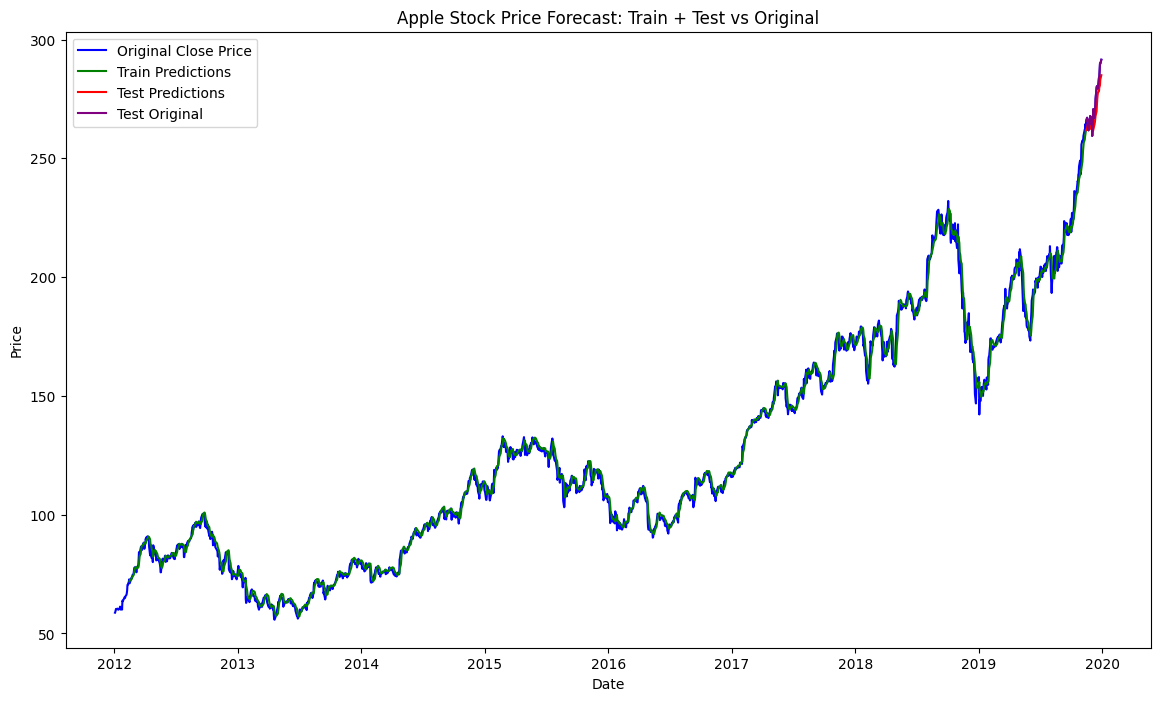

In [42]:
plt.figure(figsize=(14,8))
plt.plot(datadates.index, datadates['Close'], label='Original Close Price', color='blue')
plt.plot(train_dates, yhat_train, label='Train Predictions', color='green')
plt.plot(test_dates, yhat_test, label='Test Predictions', color='red')
plt.plot(test_dates, y_test_inve, label='Test Original', color='purple')
plt.title("Apple Stock Price Forecast: Train + Test vs Original")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

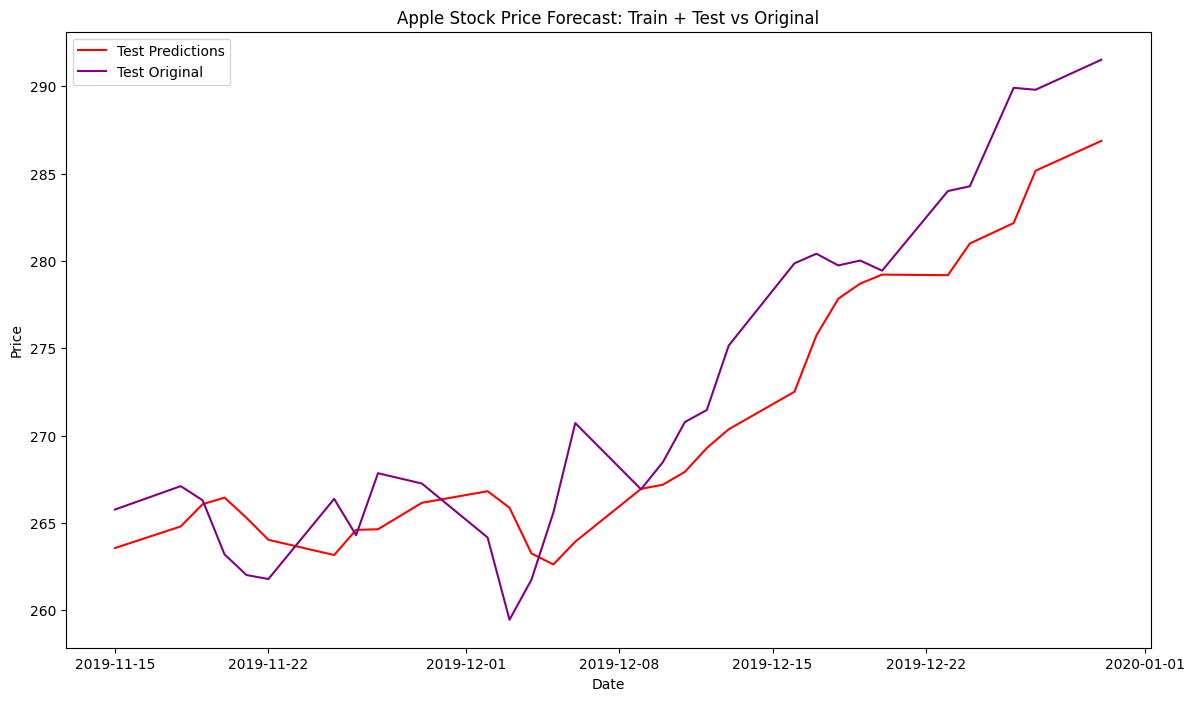

In [51]:
plt.figure(figsize=(14,8))
#plt.plot(datadates.index, datadates['Close'], label='Original Close Price', color='blue')
#plt.plot(train_dates, yhat_train, label='Train Predictions', color='green')
plt.plot(test_dates, yhat_test, label='Test Predictions', color='red')
plt.plot(test_dates, y_test_inve, label='Test Original', color='purple')
plt.title("Apple Stock Price Forecast: Train + Test vs Original")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Saving the fitted model

In [43]:
final_lstm.model_.save('final_lstm_model.keras')

# Model Registration in Azure

In [45]:
from azure.ai.ml.entities import Model

registered_model = ml_client.models.create_or_update(Model(
    name = 'apple_stock_final_lstm',
    version = "2",
    path = 'final_lstm_model.keras',
    description= 'This is the single feature lookback model'
))

Uploading final_lstm_model.keras (< 1 MB): 100%|██████████| 59.6k/59.6k [00:00<00:00, 3.46MB/s]




# Pipeline

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin
import joblib


class LSTMForecastWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_path = 'final_lstm_model.keras',
                lookback = 30, horizon = 7):
        self.model = tf.keras.models.load_model(model_path)
        self.lookback = lookback
        self.horizon = horizon
        self.scaler = MinMaxScaler(feature_range=(0,1))
    
    def fit(self, X, y= None):
        return self
    
    def predict(self, X):
        scaled = self.scaler.fit_transform(np.array(X).reshape(-1,1))

        if len(scaled)<self.lookback:
            print(f"Need atleast {self.lookback} data points")

        seq = scaled[-self.lookback:,0]
        predictions = []

        current_seq = seq.copy()
        
        for _ in range(self.horizon):
            pred = self.model.predict(current_seq.reshape(1,self.lookback,1))
            predictions.append(pred[0][0])
            current_seq = np.append(current_seq[1:], pred[0][0])

        predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1,1))
        return predictions.flatten().tolist()


In [47]:
from sklearn.pipeline import Pipeline

lstm_pipe = Pipeline([
    ('lstm_forecast' , LSTMForecastWrapper(model_path ='final_lstm_model.keras', lookback = 30, horizon =7))
])

joblib.dump(lstm_pipe, 'final_lstm_pipline.pkl')

['final_lstm_pipline.pkl']

In [48]:
new_data = np.array([356, 332, 348, 335, 323, 352, 339, 326, 358, 344, 
 330, 337, 354, 328, 360, 342, 324, 351, 329, 334, 
 347, 325, 355, 338, 327, 341, 333, 357, 340, 322])

In [49]:
lstm_pipe.named_steps['lstm_forecast'].horizon = 14
new_pred = lstm_pipe.predict(new_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [23]:
new_pred

[334.89794921875,
 334.8243408203125,
 334.95770263671875,
 335.2235107421875,
 335.5810852050781,
 336.0010681152344,
 336.4620361328125,
 336.9495849609375,
 337.453125,
 337.964599609375,
 338.4791259765625,
 338.9927978515625,
 339.50262451171875,
 340.0063171386719]

In [28]:
import sys
print(sys.path)


['/anaconda/envs/azureml_py310_sdkv2/lib/python310.zip', '/anaconda/envs/azureml_py310_sdkv2/lib/python3.10', '/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/lib-dynload', '', '/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages', '/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/setuptools/_vendor', '/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/azureml/_project/vendor']


In [29]:
sys.path.append("/path/to/apple_stock_forecast")
